In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from fastai import *
from fastai.text import *

import re
import sentencepiece as spm #https://github.com/google/sentencepiece

In [4]:
np.random.seed(20190123)

In [5]:
PATH = Path('/home/farzin/rnn_python_code/wiki103_from_download')

### Pull and prep IMDB data for supervised and unsupervised step

In [6]:
IMDB_PATH = untar_data(URLs.IMDB)
IMDB_PATH

PosixPath('/home/farzin/.fastai/data/imdb')

In [7]:
CLAS_PATH = PATH/'clas_bwd'
LM_PATH = PATH/'lm_bwd'
os.makedirs(CLAS_PATH, exist_ok=True)
os.makedirs(LM_PATH, exist_ok=True)

In [8]:
## raw data does not have the unsup in the train directory.  Just move it there
#  ~/.fastai/data/imdb$ mv unsup/ ./train/
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels,scores = [],[],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf8').read())
            labels.append(idx)
            review_name = listify(fname.parts)[-1].split('.')[0]
            scores.append( int(review_name.split("_")[1]) )

    return np.array(texts),np.array(labels),np.array(scores)

train_texts,train_labels,train_scr = get_texts(IMDB_PATH/'train')
valid_texts,valid_labels,valid_scr = get_texts(IMDB_PATH/'test')

In [9]:
len(train_texts),len(valid_texts)

(75000, 25000)

In [10]:
train_idx = np.random.permutation(len(train_texts))
valid_idx = np.random.permutation(len(valid_texts))

train_texts,train_labels,train_scr = train_texts[train_idx],train_labels[train_idx],train_scr[train_idx]
valid_texts,valid_labels,valid_scr = valid_texts[valid_idx],valid_labels[valid_idx],valid_scr[valid_idx]

In [11]:
train_df = pd.DataFrame({'text':train_texts, 'labels':train_labels, 'rating':train_scr}, columns=['labels','text','rating'])
valid_df = pd.DataFrame({'text':valid_texts, 'labels':valid_labels, 'rating':valid_scr}, columns=['labels','text','rating'])

In [12]:
for this_cls in range(3):
    print(train_df[train_df.labels == this_cls]['rating'].value_counts())

1    5100
4    2696
3    2420
2    2284
Name: rating, dtype: int64
10    4732
8     3009
7     2496
9     2263
Name: rating, dtype: int64
0    50000
Name: rating, dtype: int64


In [13]:
all_texts = np.concatenate([train_texts,valid_texts])
idx = np.random.permutation(len(all_texts))
cut = int(0.1 * len(idx))
LM_train_df = pd.DataFrame({'text':all_texts[idx[cut:]], 'labels':[0] * (len(all_texts)-cut)}, columns=['labels','text'])
LM_valid_df = pd.DataFrame({'text':all_texts[idx[:cut]], 'labels':[0] * cut}, columns=['labels','text'])

In [14]:
len(all_texts),len(LM_train_df),len(LM_valid_df)

(100000, 90000, 10000)

In [15]:
LM_train_df.head()

,labels,text
0,0,Simply boring! This is one of the worst movies...
1,0,"After you've watched The Love Bug, you will no..."
2,0,The third Muppet movie is perhaps the most rel...
3,0,"A movie like the life - complex, with unexpect..."
4,0,<br /><br />I didn´t enjoy the film at all. Th...


In [16]:
CLS_train_df = train_df[train_df.labels != 2]
CLS_valid_df = valid_df[valid_df.labels != 2]
CLS_train_df.head()

,labels,text,rating
0,0,Another trashy Grade Z quickie from the prolif...,1
1,0,"This show stinks. For parents, they usually wa...",2
5,1,Just two comments....SEVEN years apart? Hardly...,7
8,0,SOME NOT-SO-SPOILY SPOILERS AHEAD<br /><br />W...,4
10,1,"This is a very funny movie, easy to watch, tha...",7


### Tokenizer

In [17]:
def sub_br(t:str) -> str:
    "Replaces the <br /> by \n"
    re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
    return re_br.sub("\n", t)

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, rm_useless_spaces, sub_br]
default_spec_tok = [BOS, FLD, UNK, PAD]

## this is setup for BWD case, with custom Tokenizer() class
tokenizer = Tokenizer(pre_rules=default_rules, special_cases=[BOS, FLD, 'xxunk', 'xxpad'], n_cpus=4,bwd_toks=True)
tokenizer

Tokenizer SpacyTokenizer in en with the following rules:
 - fixup
 - replace_rep
 - replace_wrep
 - deal_caps
 - spec_add_spaces
 - rm_useless_spaces
 - sub_br
 - replace_all_caps
 - deal_caps

### Build LM DataBunch

In [21]:
max_vocab = 60000 #can we make this the full possible vocab at 260k?

keyword_args = {'max_vocab':max_vocab}
imdb_data_lm = TextLMDataBunch.from_df(LM_PATH, LM_train_df, LM_valid_df, tokenizer=tokenizer,
                               text_cols='text', label_cols='labels',**keyword_args)

In [19]:
imdb_data_lm.save('lm_data_bwd')

### finetune LM

In [20]:
bptt = 140
emb_sz,nh,nl = 400,1111,4

In [23]:
learn = language_model_learner(imdb_data_lm,bptt,emb_sz,nh,nl,drop_mult=0.5,qrnn=True, 
                               pretrained_fnames=['wiki103_raw_articles_spacy_BWD_20190123',
                                                  'itos_raw_spacy'])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


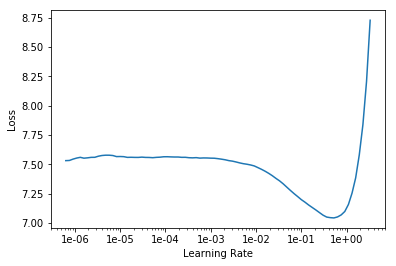

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7), wd=0.03, pct_start=0.25)

epoch,train_loss,valid_loss,accuracy
1,4.910686,4.731900,0.244333


In [26]:
learn.save('fit_head_bwd')

In [27]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.9,0.75), wd=0.01, pct_start=0.25)

epoch,train_loss,valid_loss,accuracy
1,4.631639,4.496713,0.267463
2,4.468457,4.336883,0.283023
3,4.374462,4.249422,0.291475
4,4.335640,4.195748,0.296655
5,4.281790,4.154370,0.300653
6,4.244815,4.126259,0.303676
7,4.218197,4.104016,0.306006
8,4.174376,4.088624,0.307699
9,4.144981,4.081542,0.308560
10,4.124908,4.079950,0.308787


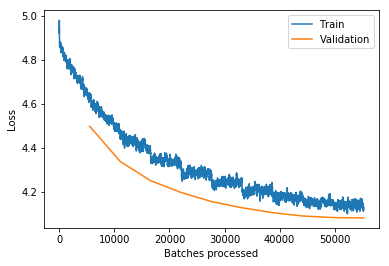

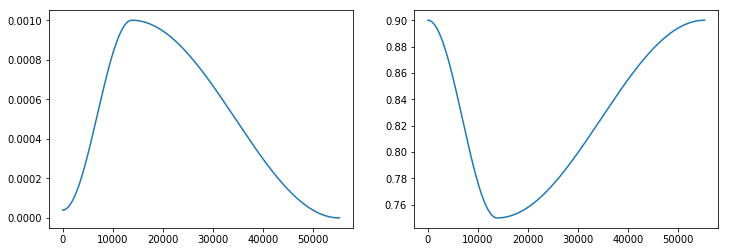

In [28]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)

In [29]:
learn.save('fine_tuned60kb_bwd')
learn.save_encoder('fine_tuned_enc60kb_bwd')

In [ ]:
learn.load('fine_tuned60kb_bwd')

### Build/train classifier

In [30]:
CLS_train_df.head()

,labels,text,rating
0,0,Another trashy Grade Z quickie from the prolif...,1
1,0,"This show stinks. For parents, they usually wa...",2
5,1,Just two comments....SEVEN years apart? Hardly...,7
8,0,SOME NOT-SO-SPOILY SPOILERS AHEAD<br /><br />W...,4
10,1,"This is a very funny movie, easy to watch, tha...",7


In [31]:
imdb_data_clas = TextClasDataBunch.from_df(CLAS_PATH,CLS_train_df,CLS_valid_df, tokenizer=tokenizer,
                                           vocab=imdb_data_lm.train_ds.vocab,label_cols='labels',text_cols='text')

In [32]:
del learn
torch.cuda.empty_cache()

In [34]:
imdb_data_clas.batch_size = 16
learn_cls = text_classifier_learner(imdb_data_clas,bptt,emb_sz,nh,nl,drop_mult=0.5,qrnn=True)
learn_cls.load_encoder('fine_tuned_enc60kb_bwd')
learn_cls.freeze()
learn_cls

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (25000 items)
[Category 0, Category 0, Category 1, Category 0, Category 1]...
Path: /home/farzin/rnn_python_code/wiki103_from_download/clas_bwd
x: TextList (25000 items)
[Text xxbos 

 ) * 4 xxrep of ( 0 

 . possible that´s if , worse even reportedly is ´ toys demonic vs. dollman ´ sequel ? it xxunk , movies these watch we why that´s but , bad laughably . shot second every in reappears and disappears sunglasses xxunk how note : too , guy continuity the fired have should they . woman ft 50 the of attack since effects cheesiest the with , dull xxunk but , short mercifully ! bronx south in war gang a in involved gets and earth to ) ! ( head flying ugly an chases space outer from cop like - eastwood clint inch 13 xxunk tim . pyun albert prolific the from quickie z grade trashy another, Text xxbos . up grow to how know never 'll they . it see to kids your want n't wo you 2 of age the past but , entertaining 's it , kids f

In [ ]:
lr_find(learn_cls)

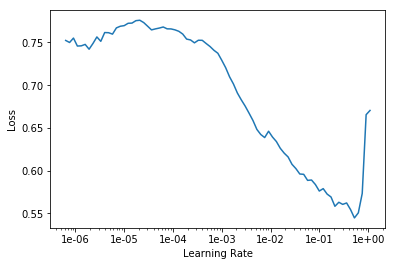

In [36]:
learn_cls.recorder.plot()

In [37]:
learn_cls.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.377595,0.262159,0.899200


In [38]:
learn_cls.fit_one_cycle(2, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.448531,0.298936,0.877680
2,0.369926,0.259925,0.905760


In [39]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2, slice(1e-1/2.6,1e-1), moms=(0.8,0.7), pct_start=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.357873,0.686789,0.885000
2,0.290814,0.220855,0.921440


In [40]:
learn_cls.save('second_bwd')

In [41]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(3, slice(1e-2/(2.6**2),3e-2), moms=(0.9,0.7), pct_start=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.322946,0.400557,0.908200
2,0.294446,0.337991,0.922640
3,0.236637,0.818094,0.924080


In [42]:
learn_cls.fit_one_cycle(3, slice(1e-2/(2.6**2),3e-2), moms=(0.9,0.7), pct_start=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.296635,0.235310,0.910840
2,0.289384,2.694395,0.912960
3,0.277817,0.264012,0.923920


In [43]:
learn_cls.save('third_bwd')

In [54]:
learn_cls.load('third_bwd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (25000 items)
[Category 0, Category 0, Category 1, Category 0, Category 1]...
Path: /home/farzin/rnn_python_code/wiki103_from_download/clas
x: TextList (25000 items)
[Text xxbos another trashy grade z quickie from the prolific albert pyun . tim xxunk 13 inch clint eastwood - like cop from outer space chases an ugly flying head ( ! ) to earth and gets involved in a gang war in south bronx ! mercifully short , but xxunk dull , with the cheesiest effects since attack of the 50 ft woman . they should have fired the continuity guy , too : note how xxunk sunglasses disappears and reappears in every second shot . laughably bad , but that´s why we watch these movies , xxunk it ? sequel ´ dollman vs. demonic toys ´ is reportedly even worse , if that´s possible . 

 0 ( of xxrep 4 * ) 

, Text xxbos this show stinks . for parents , they usually want their kids to watch something good for them . it is usually educational , funny

In [44]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(3, slice(1e-2/(2.6**4),3e-2), moms=(0.8,0.7), pct_start=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.312428,0.247771,0.923800
2,0.237559,0.193471,0.929160
3,0.251314,0.191734,0.931760


In [45]:
learn_cls.save('final_bwd')

In [ ]:
del learn_cls

In [171]:
torch.cuda.empty_cache()

## Investigate mis-labeled cases in train set. 
Are they marginal reviews?  Other details that could be better addressed?

In [24]:
learn_cls.load('final')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (25000 items)
[Category 0, Category 0, Category 1, Category 0, Category 1]...
Path: /home/farzin/rnn_python_code/wiki103_from_download/clas
x: TextList (25000 items)
[Text xxbos another trashy grade z quickie from the prolific albert pyun . tim xxunk 13 inch clint eastwood - like cop from outer space chases an ugly flying head ( ! ) to earth and gets involved in a gang war in south bronx ! mercifully short , but xxunk dull , with the cheesiest effects since attack of the 50 ft woman . they should have fired the continuity guy , too : note how xxunk sunglasses disappears and reappears in every second shot . laughably bad , but that´s why we watch these movies , xxunk it ? sequel ´ dollman vs. demonic toys ´ is reportedly even worse , if that´s possible . 

 0 ( of xxrep 4 * ) 

, Text xxbos this show stinks . for parents , they usually want their kids to watch something good for them . it is usually educational , funny

In [136]:
learn_cls.data.batch_size = 8

In [168]:
DatasetType.Fix

<DatasetType.Fix: 5>

In [56]:
y_hat, y_true = learn_cls.get_preds(DatasetType.Valid,ordered=True)
trn_df = CLS_valid_df.copy()

In [57]:
trn_df['pred0'] = to_np(y_hat)[:,0]
trn_df['pred1'] = to_np(y_hat)[:,1]
trn_df['pred_label']= to_np(y_hat).argmax(axis=1)

In [58]:
to_np(y_true)[:20]

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [59]:
trn_df.labels.values[:20]

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [60]:
trn_df.head(20)

,labels,text,rating,pred0,pred1,pred_label
0,0,I thought it will be a Ok movie after seeing t...,1,0.906678,0.093322,0
1,0,"I enjoyed Carax's ""Les Amants du Pont Neuf"" an...",4,0.994287,0.005713,0
2,1,What's the matter with you people? John Dahl? ...,10,0.016465,0.983535,1
3,0,Johnnie (Bert Wheeler) is a would-be songwrite...,3,0.898954,0.101046,0
4,1,This film has the guts to suggest that it migh...,8,0.002427,0.997573,1
5,1,"I saw Ray when it first came out. Why? Partly,...",7,0.535921,0.464079,0
6,1,Who ARE the people that star in this thing? Ne...,8,0.007283,0.992717,1
7,1,One of Starewicz's longest and strangest short...,8,0.008810,0.991190,1
8,1,The three names that mean the most to this fil...,7,0.004281,0.995719,1
9,1,By far one of the best sci-fi films out there....,10,0.005068,0.994932,1


In [62]:
1.-(trn_df.pred_label != trn_df.labels).sum()/len(trn_df)

0.93176

In [61]:
trn_df.to_csv('bwd_training_classification.csv')

Indeed, many of the marginal ratings (4 & 7) are a greater % of the errors

In [52]:
trn_df[trn_df.pred_label != trn_df.labels].rating.value_counts().sort_index()

1     141
2      83
3     118
4     280
7     345
8     185
9      74
10    188
Name: rating, dtype: int64

In [53]:
trn_df.rating.value_counts().sort_index()

1     5100
2     2284
3     2420
4     2696
7     2496
8     3009
9     2263
10    4732
Name: rating, dtype: int64

In [54]:
trn_df[trn_df.pred_label != trn_df.labels].rating.value_counts().sort_index() / trn_df.rating.value_counts().sort_index()

1     0.027647
2     0.036340
3     0.048760
4     0.103858
7     0.138221
8     0.061482
9     0.032700
10    0.039730
Name: rating, dtype: float64